<a href="https://colab.research.google.com/github/sohang576/Sentiment_Analyzer/blob/main/Sentiment_Analyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers datasets evaluate

!pip install --upgrade transformers

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
import evaluate

# Load the IMDB dataset
dataset = load_dataset("imdb")

# Inspect dataset splits
print(dataset)


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer

# Load dataset
dataset = load_dataset("imdb")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=256)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Split train and test datasets
tokenized_train_dataset = tokenized_dataset["train"]
tokenized_eval_dataset = tokenized_dataset["test"]


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=predictions, references=labels)


In [ ]:
import transformers
print(transformers.__version__)


4.55.0


In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"


from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
import numpy as np
import evaluate

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# Optional: Define metric for evaluation
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=500,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.evaluate()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-735491753.py:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.348300
1000,0.274600
1500,0.260000
2000,0.186900
2500,0.169500
3000,0.167800
3500,0.116000
4000,0.108000
4500,0.106600


{'eval_loss': 0.3352552354335785,
 'eval_accuracy': 0.9152,
 'eval_runtime': 166.619,
 'eval_samples_per_second': 150.043,
 'eval_steps_per_second': 9.381,
 'epoch': 3.0}

In [ ]:
import torch


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=256)

    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        pred = torch.argmax(probs).item()

    labels = ["negative", "positive"]
    return labels[pred], probs[0][pred].item()


print(predict_sentiment("I did not really loved this movie!"))
print(predict_sentiment("The film was boring and too long."))


('negative', 0.9873757362365723)
('negative', 0.9968286156654358)


In [ ]:
model.save_pretrained("./sentiment_model")
tokenizer.save_pretrained("./sentiment_model")


('./sentiment_model/tokenizer_config.json',
 './sentiment_model/special_tokens_map.json',
 './sentiment_model/vocab.txt',
 './sentiment_model/added_tokens.json',
 './sentiment_model/tokenizer.json')

In [ ]:
pip install scikit-learn matplotlib


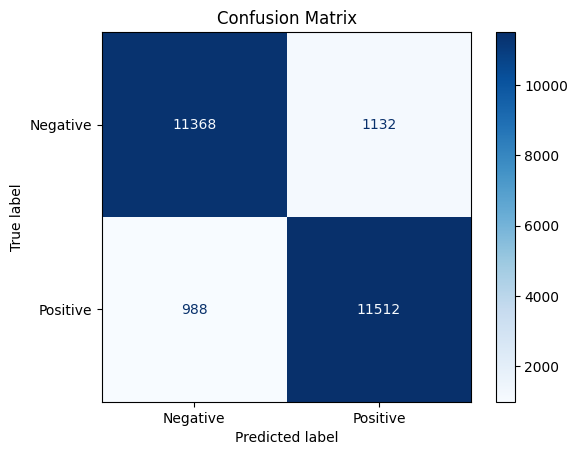

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# After your model evaluation, get predictions and true labels:

# Suppose eval_dataset is your test set
predictions_output = trainer.predict(tokenized_eval_dataset)
logits = predictions_output.predictions
labels = predictions_output.label_ids

# Convert logits to predicted class indices
preds = np.argmax(logits, axis=1)

# Compute confusion matrix
cm = confusion_matrix(labels, preds)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
